In [1]:
import tensorflow as tf
from tensorflow import keras
import PIL
import os
from PIL import Image
from skimage.io import imread_collection
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import pandas as pd
import re

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [4]:
def sorted_nicely(l):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [5]:
images=[]
names=[]
for files in sorted_nicely( os.listdir('training_images') ):
    try:
        mypath = os.path.join('training_images',files)
        img=Image.open(mypath, mode='r')
        img = img.resize((128,128))
        arr = np.array(img).astype('uint8')
        images.append(arr)
        img.close()
    except:
        pass

In [ ]:
speeds = pd.read_csv('train_wheel_speeds.csv')

In [31]:
def absSobelThresh(img, orient, thresh, sobelKernel = 19):
    
    threshMin=thresh[0]
    threshMax=thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    else:
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    absSobel = np.absolute(sobelOp)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sxbinary = np.zeros_like(scaledSobel)
    sxbinary[(scaledSobel > threshMin) & (scaledSobel < threshMax)] = 1
    binaryOutput = sxbinary 
    
    return binaryOutput

def combinedThreshBinaryImg(img, threshX, threshY, threshColorS, threshColorU, threshColorR):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.float)
    L = hls[:,:,1]
    S = hls[:,:,2]
    R = rgb[:,:,0]
    U = yuv[:,:,1]
    sobelX = absSobelThresh(img, orient='x', thresh=(threshX[0], threshX[1]))
    sobelY = absSobelThresh(img, orient='y', thresh=(threshY[0], threshY[1]))
    sBinary = np.zeros_like(S)
    sBinary[(S >= threshColorS[0]) & (S <= threshColorS[1])] = 1
    rBinary = np.zeros_like(R)
    rBinary[(R >= threshColorR[0]) & (R <= threshColorR[1])] = 1
    uBinary = np.zeros_like(U)
    uBinary[(U >= threshColorU[0]) & (U <= threshColorU[1])] = 1    
    colorBinary = np.dstack(( rBinary, ((sobelX == 1) & (sobelY == 1)), uBinary ))
    combinedBinary = np.zeros_like(sBinary)
    combinedBinary[(rBinary == 1) | (uBinary == 1) | ((sobelX == 1) & (sobelY == 1))] = 1
    
    return combinedBinary

In [6]:
images = np.array(images)

In [7]:
speeds = pd.read_csv('train_wheel_speeds.csv')

In [8]:
mask = speeds['0'] & speeds['1'] == 0

In [9]:
images = images[~mask]
speeds = speeds[~mask]

In [11]:
copymask = abs(speeds['0'] - speeds['1'])>= 20

In [12]:
turns = images[copymask]
turn_speeds = speeds[copymask]

In [13]:
oversample_images = np.concatenate((np.concatenate((np.concatenate((images, turns)), turns)),turns))
oversample_lables = pd.concat([speeds, turn_speeds,turn_speeds,turn_speeds ])

In [18]:
oversample_lables['left-right'] = oversample_lables['0'] - oversample_lables['1']

In [21]:
labels = np.array(oversample_lables['left-right'])

In [51]:
X = oversample_images
y = np.array(oversample_lables['left-right'])

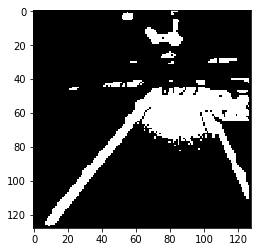

In [64]:
image = combinedThreshBinaryImg(X[40], threshX=(1, 255), 
                                                threshY=(50, 255), 
                                                threshColorS=(1,255), 
                                                threshColorU=(250,250), 
                                                threshColorR=(230,255))
plt.imshow(image,cmap = "gray")

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128, 128, 1),padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128, 128, 1),padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [15]:
history = model.fit(X, Y, epochs=10, batch_size = 320)

Epoch 1/10
  64/1011 [>.............................] - ETA: 10:15 - loss: 2175359.9662 - mean_squared_error: 2175359.9662

KeyboardInterrupt: 